<a href="https://colab.research.google.com/github/drbaijsingh/baijsingh/blob/main/CMAPSS_FD002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd
import numpy as np

columns = (
    ['engine_id', 'cycle'] +
    [f'op_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

train_df = pd.read_csv(
    '/content/train_FD002.txt',
    delim_whitespace=True,
    header=None,
    names=columns
)

train_df.head()


/tmp/ipython-input-4076461254.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(


,engine_id,cycle,op_1,op_2,op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [3]:
print("Shape:", train_df.shape)
print("Engines:", train_df.engine_id.nunique())


Shape: (53759, 26)
Engines: 260


In [4]:
train_df[['engine_id','cycle']].tail()

,engine_id,cycle
53754,260,312
53755,260,313
53756,260,314
53757,260,315
53758,260,316


In [5]:
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(max_cycle) - train_df['cycle']


In [6]:
train_df.groupby('engine_id')['RUL'].agg(['min','max']).head()


,min,max
engine_id,,
1,0,148
2,0,268
3,0,205
4,0,234
5,0,153


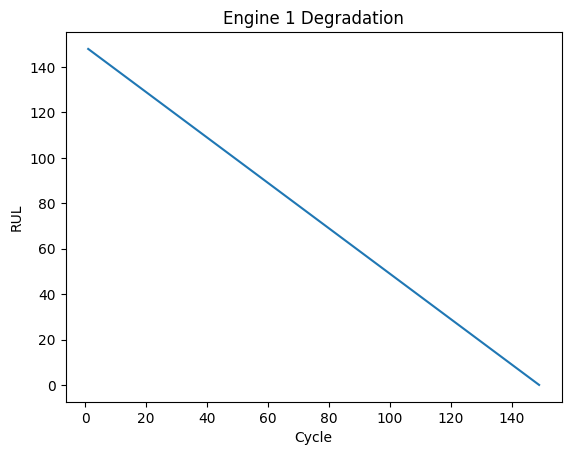

In [7]:
import matplotlib.pyplot as plt

e1 = train_df[train_df.engine_id == 1]

plt.figure()
plt.plot(e1['cycle'], e1['RUL'])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Engine 1 Degradation")
plt.show()


In [8]:
train_df.drop(columns=['op_1','op_2','op_3'], inplace=True)


In [9]:
features = [
    'sensor_2','sensor_3','sensor_4','sensor_7',
    'sensor_8','sensor_9','sensor_11','sensor_12',
    'sensor_13','sensor_14','sensor_15',
    'sensor_17','sensor_20','sensor_21'
]


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])


In [11]:
def create_sequences(df, seq_len, feature_cols):
    X, y = [], []

    for eid in df.engine_id.unique():
        edf = df[df.engine_id == eid].reset_index(drop=True)

        for i in range(len(edf) - seq_len):
            X.append(edf.loc[i:i+seq_len-1, feature_cols].values)
            y.append(edf.loc[i+seq_len, 'RUL'])

    return np.array(X), np.array(y)


In [12]:
SEQ_LEN = 30
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

print(X_train.shape)
print(y_train.shape)

(45959, 30, 14)
(45959,)


In [13]:
# Recompute RUL cleanly
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = max_cycle[train_df.engine_id].values - train_df.cycle

# Cap RUL
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Recreate sequences
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

In [14]:
RUL_CAP = 125
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)




In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Epoch 1/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 610.5158 - mae: 19.6420 - val_loss: 648.3622 - val_mae: 19.9808
Epoch 2/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 594.5901 - mae: 19.2851 - val_loss: 804.3918 - val_mae: 22.2431
Epoch 3/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 609.8571 - mae: 19.5516 - val_loss: 593.1751 - val_mae: 19.8402
Epoch 4/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 573.7573 - mae: 18.8888 - val_loss: 575.1230 - val_mae: 19.2263
Epoch 5/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 562.0341 - mae: 18.6359 - val_loss: 561.2294 - val_mae: 18.7704
Epoch 6/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 568.2701 - mae: 18.7338 - val_loss: 552.7491 - val_mae: 18.8692
Epoch 7/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 561.7859 - mae: 18.6298 - val_loss: 540.4769 - val_mae: 18.4831
Epoch 8/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 515.6581 - mae: 17.7796 - val_loss: 819.4606 - val_mae: 22.3050
Epoch 9/

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


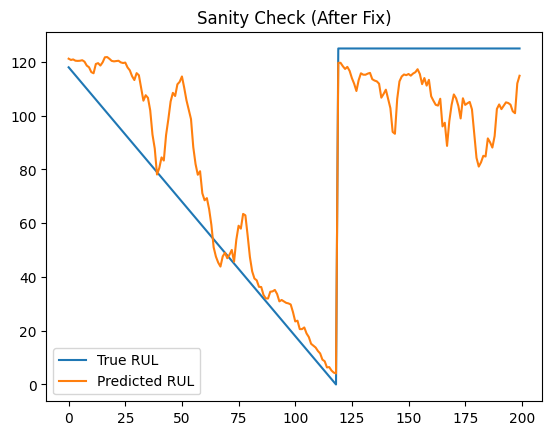

In [21]:
pred = model.predict(X_train[:200])

plt.figure()
plt.plot(y_train[:200], label='True RUL')
plt.plot(pred.flatten(), label='Predicted RUL')
plt.legend()
plt.title("Sanity Check (After Fix)")
plt.show()

In [22]:
print("Final Training MAE:", history.history['mae'][-1])
print("Final Validation MAE:", history.history['val_mae'][-1])
print("Final Training MSE:", history.history['loss'][-1])
print("Final Validation MSE:", history.history['val_loss'][-1])


Final Training MAE: 11.858755111694336
Final Validation MAE: 13.941551208496094
Final Training MSE: 252.90496826171875
Final Validation MSE: 353.5912170410156


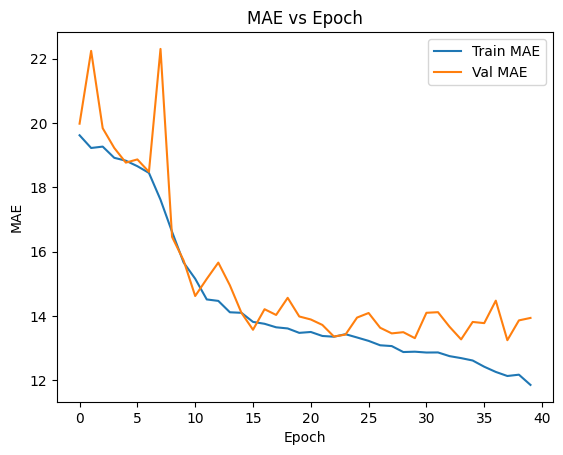

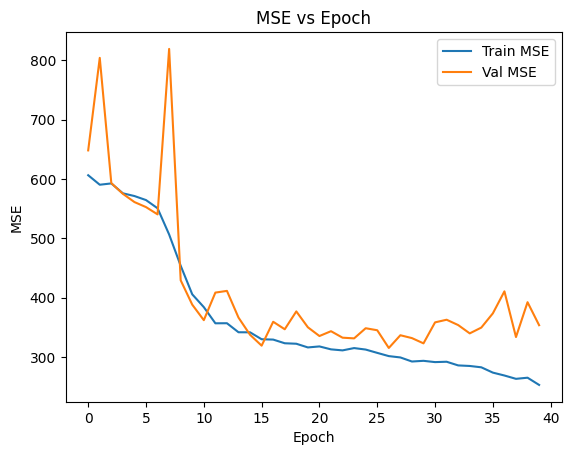

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Epoch')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epoch')
plt.show()
